# Notebook 1C. Pre-trained Convolutional Neural Networks (CNN)
---

Organized and prepared by Christopher Monterola, updated by Kenneth Co.

This notebook was conceptualized, organized, and primarily prepared for the **Machine Learning** courses.

### This notebook uses the following references:
Lecture is organized and compiled/taken from:
1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.
2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.
3. Deep Learning with Python, Francois Chollet, Manning New York 2018.
4. 2018 Google: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb

Again, here is a list of data available for potential individual mini projects: https://en.wikipedia.org/wiki/List_of_datasets_for_machine_learning_research

---

From 70-73%, we previously demonstrated how data augmentation improves the accuracy up to 83%. In this notebook, we show that book the speed and accuracy can further be enhanced by using pre-trained CNN.

## Google Colab Setup

In [9]:
import torch
import tensorflow as tf

# Check PyTorch CUDA Version
print("PyTorch CUDA Version:")
try:
    print(torch.version.cuda)
except AttributeError:
    print("CUDA not available with this PyTorch installation.")

# Check TensorFlow CUDA Version
print("\nTensorFlow CUDA Version:")
try:
    print(tf.sysconfig.get_build_info()['cuda_version'])
except KeyError:
    print("CUDA not used in this TensorFlow build.")

# Additional checks for GPU availability
print("\nGPU Availability:")
print("PyTorch CUDA Availability:", torch.cuda.is_available())
print("TensorFlow GPU Devices:", len(tf.config.list_physical_devices('GPU')) > 0)

PyTorch CUDA Version:
12.4

TensorFlow CUDA Version:
12.3

GPU Availability:
PyTorch CUDA Availability: True
TensorFlow GPU Devices: False


In [10]:
# !pip install -U keras
# !pip install -U tensorflow

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/data/'
# IMG_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/images/'
# MODEL_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/'

DATA_DIR = 'data/'
IMG_DIR = 'images/'
MODEL_DIR = 'models/'

# Why pre-trained CNNs?
---

Using a pre-trained network is a common and highly effective approach to deep learning on small image datasets. A pre-trained network is a saved network previously trained on a large dataset, typically on a large-scale image-classification task. **If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pre-trained network can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems,** even though these new problems may involve completely different classes than those of the original task. For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images.

Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective even for small-data problems. In this case, let’s consider a large CNN trained on the [ImageNet dataset](https://en.wikipedia.org/wiki/ImageNet) (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.

You’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet: [Karen Simonyan and Andrew Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recognition,” arXiv (2014)](https://arxiv.org/abs/1409.1556). Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, I chose it because its architecture is similar to what you’re already familiar with and is easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesy model names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; you’ll get used to them, because they will come up frequently if you keep doing deep learning for computer vision. There are two ways to use a pretrained network: feature extraction and fine-tuning.

Let’s start with feature extraction.

# Step 1. Feature Extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.
As you saw previously, convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a densely
connected classifier. The first part is called the convolutional base of the model. In the
case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output (see figure below).

<img width="500" alt="swapping_classifiers" src="https://user-images.githubusercontent.com/25600601/134777359-711c0dec-ed92-4910-8370-6d877fe4609b.png">

Why only reuse the convolutional base? Could you reuse the densely connected classifier as well? **In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable:** the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless. Note that the level of generality (and therefore reusability) of the representations
extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The VGG16 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of *keras.applications*:
- Xception   
- Inception V3   
- ResNet50  
- VGG16  
- VGG19  
- MobileNet  

In 2014, 16 and 19 layer networks were considered very deep (although we now have the ResNet architecture which can be successfully trained at depths of 50-200 for ImageNet and over 1,000 for CIFAR-10). Simonyan and Zisserman found training VGG16 and VGG19 challenging (specifically regarding convergence on the deeper networks), so in order to make training easier, they first trained smaller versions of VGG with less weight layers (columns A and C) first.

The smaller networks converged and were then used as initializations for the larger, deeper networks — this process is called *pre-training*.

While making logical sense, pre-training is a very time consuming, tedious task, requiring an entire network to be trained before it can serve as an initialization for a deeper network.

Let’s instantiate the VGG16 model or OxfordNet. VGG means Visual Geometry Group from Oxford with 16 layers as shown below:

<img width="800" alt="VGG16" src="https://user-images.githubusercontent.com/25600601/134777383-0be97327-da9d-42d0-b98c-751599ec7b3d.png">

The 16 layers are:
1. Convolution using 64 filters
2. Convolution using 64 filters + Max pooling
3. Convolution using 128 filters
4. Convolution using 128 filters + Max pooling
5. Convolution using 256 filters
6. Convolution using 256 filters
7. Convolution using 256 filters + Max pooling
8. Convolution using 512 filters
9. Convolution using 512 filters
10. Convolution using 512 filters + Max pooling
11. Convolution using 512 filters
12. Convolution using 512 filters
13. Convolution using 512 filters + Max pooling
14. Fully connected with 4096 nodes
15. Fully connected with 4096 nodes
16. Output layer with Softmax activation with 4096(above figure) or 1000 (below figure) nodes

<img width="800" alt="VGG16_fullview" src="https://user-images.githubusercontent.com/25600601/134777407-4e99ec7b-cad7-440a-bb06-5c7d01c55491.png">

## Step 1A. Instantiate the VGG16 convolutional base

In [18]:
import torch
import torchvision.models as models
from torchinfo import summary

# Load the VGG16 model from torchvision
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

# Print the model summary
summary(vgg16, input_size=(1, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 150, 150]         1,792
│    └─ReLU: 2-2                         [1, 64, 150, 150]         --
│    └─Conv2d: 2-3                       [1, 64, 150, 150]         36,928
│    └─ReLU: 2-4                         [1, 64, 150, 150]         --
│    └─MaxPool2d: 2-5                    [1, 64, 75, 75]           --
│    └─Conv2d: 2-6                       [1, 128, 75, 75]          73,856
│    └─ReLU: 2-7                         [1, 128, 75, 75]          --
│    └─Conv2d: 2-8                       [1, 128, 75, 75]          147,584
│    └─ReLU: 2-9                         [1, 128, 75, 75]          --
│    └─MaxPool2d: 2-10                   [1, 128, 37, 37]          --
│    └─Conv2d: 2-11                      [1, 256, 37, 37]          29

In [45]:
import torch
import torchvision.models as models

# Load VGG16 model with pre-trained weights, excluding the top layers
conv_base = models.vgg16(pretrained=True)
conv_base = conv_base.features

# Set the model to evaluation mode
conv_base.eval()

# Print the model summary
summary(conv_base, input_size=(1, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 4, 4]            --
├─Conv2d: 1-1                            [1, 64, 150, 150]         1,792
├─ReLU: 1-2                              [1, 64, 150, 150]         --
├─Conv2d: 1-3                            [1, 64, 150, 150]         36,928
├─ReLU: 1-4                              [1, 64, 150, 150]         --
├─MaxPool2d: 1-5                         [1, 64, 75, 75]           --
├─Conv2d: 1-6                            [1, 128, 75, 75]          73,856
├─ReLU: 1-7                              [1, 128, 75, 75]          --
├─Conv2d: 1-8                            [1, 128, 75, 75]          147,584
├─ReLU: 1-9                              [1, 128, 75, 75]          --
├─MaxPool2d: 1-10                        [1, 128, 37, 37]          --
├─Conv2d: 1-11                           [1, 256, 37, 37]          295,168
├─ReLU: 1-12                             [1, 256, 37, 37]       

The final feature map `MaxPool2d: 1-31` has shape (4, 4, 512). That's the feature on top of which you'll stick a densely connected classifier.

At this point, there are two ways you could proceed:

1. Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won't allow you to use data augmentation.

2. Extending the model you have `conv_base` by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first. We'll cover both techniques. Let's walk through the code required to set up the first
one: recording the output of `conv_base` on your data and using these outputs as inputs to a new model.

## Step 1B. Fast feature extraction without Data Augmentation

You’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. You’ll extract features from these images by calling the predict method of the *conv_base* model.

### Extracting features using the pretrained convolutional base

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [47]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

In [48]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered_extracted/cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

Let's look at how many cats and dogs images we have in our training and validation directory

In [49]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [50]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [51]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [52]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

# Define the batch size
BATCH_SIZE = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_base = conv_base.to(device)

# Define transforms for the data
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

def extract_features(directory, sample_count):
    dataset = ImageFolder(root=directory, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    features = torch.zeros((sample_count, 512, 4, 4))  # Note: PyTorch uses (C, H, W) for tensor shape
    labels = torch.zeros((sample_count))
    count = 0
    
    conv_base.eval()  # Set to evaluation mode
    with torch.no_grad():  # No need to track gradients
        for i, (inputs, targets) in enumerate(loader):
            outputs = conv_base(inputs.to(device))
            features[count:count+len(inputs)] = outputs
            labels[count:count+len(inputs)] = targets
            count += len(inputs)
            if count >= sample_count:
                break

    return features, labels

# Assuming `train_dir` and `validation_dir` are defined paths
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

# Convert to numpy if needed for further processing
train_features = train_features.numpy().transpose(0, 2, 3, 1)  # Convert to (N, H, W, C)
train_labels = train_labels.numpy()
validation_features = validation_features.numpy().transpose(0, 2, 3, 1)
validation_labels = validation_labels.numpy()

The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [53]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [55]:
len(train_features[0])

8192

In [56]:
sum(validation_labels)

500.0

In [57]:
train_features.shape

(2000, 8192)

At this point, you can define your densely connected classifier (note the use of dropout
for regularization) and train it on the data and labels that you just recorded.

# Step 2. Define and train the densely connected classifier

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Custom model using the VGG16 features
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(4 * 4 * 512, 256),  # Input_dim matches the output of VGG16 when input size is 150x150
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

model = CustomModel()

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.RMSprop(model.parameters(), lr=2e-5)

# Convert numpy arrays to tensors while ensuring proper handling of gradients
train_features_torch = torch.from_numpy(train_features).float()  # Assuming train_features is a numpy array
train_labels_torch = torch.from_numpy(train_labels).float().unsqueeze(1)  # Reshape to match output shape

validation_features_torch = torch.from_numpy(validation_features).float()
validation_labels_torch = torch.from_numpy(validation_labels).float().unsqueeze(1)

# Create datasets
train_dataset = TensorDataset(train_features_torch, train_labels_torch)
validation_dataset = TensorDataset(validation_features_torch, validation_labels_torch)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Store training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Training loop
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * batch_features.size(0)
        preds = (outputs > 0.5).float()
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)
        
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_features, batch_labels in validation_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item() * batch_features.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == batch_labels).sum().item()
            val_total += batch_labels.size(0)

    # Calculate average losses and accuracies for the epoch
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Store the results in the history dictionary
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%')

Epoch [1/50], Train Loss: 0.2432, Train Acc: 91.45%, Val Loss: 0.1687, Val Acc: 94.80%
Epoch [2/50], Train Loss: 0.1398, Train Acc: 95.45%, Val Loss: 0.1448, Val Acc: 94.60%
Epoch [3/50], Train Loss: 0.1076, Train Acc: 96.45%, Val Loss: 0.1322, Val Acc: 95.20%
Epoch [4/50], Train Loss: 0.0888, Train Acc: 97.20%, Val Loss: 0.1253, Val Acc: 95.20%
Epoch [5/50], Train Loss: 0.0710, Train Acc: 98.35%, Val Loss: 0.1218, Val Acc: 95.50%
Epoch [6/50], Train Loss: 0.0601, Train Acc: 98.95%, Val Loss: 0.1185, Val Acc: 96.00%
Epoch [7/50], Train Loss: 0.0502, Train Acc: 99.25%, Val Loss: 0.1147, Val Acc: 95.40%
Epoch [8/50], Train Loss: 0.0416, Train Acc: 99.40%, Val Loss: 0.1166, Val Acc: 95.70%
Epoch [9/50], Train Loss: 0.0334, Train Acc: 99.80%, Val Loss: 0.1130, Val Acc: 95.70%
Epoch [10/50], Train Loss: 0.0280, Train Acc: 99.90%, Val Loss: 0.1168, Val Acc: 95.80%
Epoch [11/50], Train Loss: 0.0229, Train Acc: 99.95%, Val Loss: 0.1162, Val Acc: 95.50%
Epoch [12/50], Train Loss: 0.0190, Train 

Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU. Let’s look at the loss and accuracy curves during training (see below)

# Step 3. Plot the results

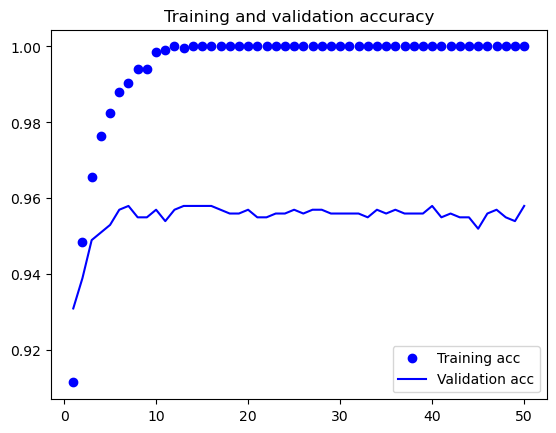

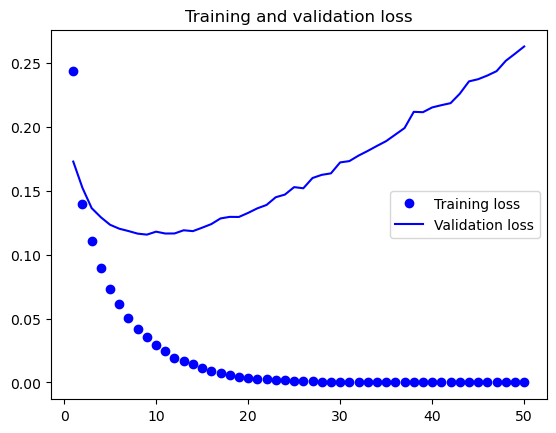

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

You reach a validation accuracy of about 95%—much better than you achieved previously with the small model trained from scratch. But the plots also indicate that you’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

<div class="alert alert-block alert-success">

### Recap of Model Performance
1. Small CNN (70-73%)
2. Small CNN + Data Augmentation and Dropout (83%)
3. VGG16 with frozen Dense Layer (95%)

</div>

# Step 4. (SLOW) Feature extraction with data augmentation
Now, let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: extending the conv_base model and running it end to end on the inputs.

<div class="alert alert-block alert-warning">

**NOTE: This technique is so expensive that if you can't run your code on GPU, then the previous technique is the way to go.**

</div>

Because models behave just like layers, you can add a model (like conv_base) to a Sequential model just like you would add a layer.

## Step 4A. Add a densely connected classifier on top of the convolutional base

In [93]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

# Load pre-trained VGG16 model
vgg = vgg16(pretrained=True)

# Remove the final classifier layers since we only want the convolutional base
# VGG16 features are returned up to the last convolutional layer
conv_base = nn.Sequential(*list(vgg.features.children()))

# Define the model
class CustomVGG16(nn.Module):
    def __init__(self, conv_base):
        super(CustomVGG16, self).__init__()
        self.conv_base = conv_base
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 4 * 4, 256)  # Assuming VGG16 with 7x7 feature map after conv layers
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model
model = CustomVGG16(conv_base)

# Print trainable parameters before and after freezing the conv_base
print('This is the number of trainable weights before freezing the conv base:', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

# Freeze the conv_base parameters
for param in model.conv_base.parameters():
    param.requires_grad = False

print('This is the number of trainable weights after freezing the conv base:', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

This is the number of trainable weights before freezing the conv base: 16812353
This is the number of trainable weights after freezing the conv base: 2097665


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously
learned.

With this setup, only the weights from the two Dense layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored.

Now you can start training your model, with the same data-augmentation configuration that you used in the previous example. This will take a very long time if you will not run this using GPU, see example below!

## Step 4B.  Training the model end to end with a frozen convolutional base

In [117]:
BATCH_SIZE = 40

In [95]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for training data
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Define transformations for validation data (only normalization)
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Assuming 'train_dir' and 'validation_dir' are paths to your directories
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [97]:
from tqdm import tqdm

# Check CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

# Move model to device
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Store training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1)) # Calculate loss - ensure labels are float and have correct shape

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item() * images.size(0)  # Multiply by batch size to get total loss for this batch
        preds = (outputs > 0.5).float() # Convert probabilities to binary predictions
        train_correct += (preds == labels.float().unsqueeze(1)).sum().item() # Count correct predictions

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():  # No need to track gradients during validation
        for images, labels in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))

            # Statistics
            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels.float().unsqueeze(1)).sum().item()

    # Calculate average losses and accuracies for the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss = val_loss / len(validation_loader.dataset)
    val_acc = val_correct / len(validation_loader.dataset)

    # Store the results in the history dictionary
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

CUDA is available. Training on GPU.


Epoch 1/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.27it/s]


Epoch 1/50: Train Loss: 0.2643, Train Acc: 0.8875, Val Loss: 0.1708, Val Acc: 0.9430


Epoch 2/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.31it/s]


Epoch 2/50: Train Loss: 0.2387, Train Acc: 0.9035, Val Loss: 0.1844, Val Acc: 0.9330


Epoch 3/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.48it/s]


Epoch 3/50: Train Loss: 0.2139, Train Acc: 0.9160, Val Loss: 0.1467, Val Acc: 0.9410


Epoch 4/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.63it/s]


Epoch 4/50: Train Loss: 0.1972, Train Acc: 0.9175, Val Loss: 0.1654, Val Acc: 0.9380


Epoch 5/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


Epoch 5/50: Train Loss: 0.1691, Train Acc: 0.9290, Val Loss: 0.1459, Val Acc: 0.9440


Epoch 6/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]


Epoch 6/50: Train Loss: 0.1525, Train Acc: 0.9395, Val Loss: 0.2107, Val Acc: 0.9290


Epoch 7/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Epoch 7/50: Train Loss: 0.1554, Train Acc: 0.9375, Val Loss: 0.1807, Val Acc: 0.9400


Epoch 8/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]


Epoch 8/50: Train Loss: 0.1530, Train Acc: 0.9325, Val Loss: 0.1951, Val Acc: 0.9330


Epoch 9/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 9/50: Train Loss: 0.1205, Train Acc: 0.9510, Val Loss: 0.1963, Val Acc: 0.9290


Epoch 10/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


Epoch 10/50: Train Loss: 0.1205, Train Acc: 0.9510, Val Loss: 0.2125, Val Acc: 0.9290


Epoch 11/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


Epoch 11/50: Train Loss: 0.1234, Train Acc: 0.9490, Val Loss: 0.1625, Val Acc: 0.9480


Epoch 12/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.53it/s]


Epoch 12/50: Train Loss: 0.1210, Train Acc: 0.9510, Val Loss: 0.1649, Val Acc: 0.9490


Epoch 13/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.59it/s]


Epoch 13/50: Train Loss: 0.0997, Train Acc: 0.9585, Val Loss: 0.1913, Val Acc: 0.9390


Epoch 14/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Epoch 14/50: Train Loss: 0.0841, Train Acc: 0.9630, Val Loss: 0.1997, Val Acc: 0.9510


Epoch 15/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Epoch 15/50: Train Loss: 0.0996, Train Acc: 0.9590, Val Loss: 0.1953, Val Acc: 0.9510


Epoch 16/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 16/50: Train Loss: 0.1019, Train Acc: 0.9610, Val Loss: 0.2285, Val Acc: 0.9380


Epoch 17/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


Epoch 17/50: Train Loss: 0.0900, Train Acc: 0.9650, Val Loss: 0.1907, Val Acc: 0.9510


Epoch 18/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


Epoch 18/50: Train Loss: 0.0875, Train Acc: 0.9715, Val Loss: 0.1710, Val Acc: 0.9510


Epoch 19/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


Epoch 19/50: Train Loss: 0.0832, Train Acc: 0.9695, Val Loss: 0.2088, Val Acc: 0.9440


Epoch 20/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]


Epoch 20/50: Train Loss: 0.0735, Train Acc: 0.9755, Val Loss: 0.2206, Val Acc: 0.9440


Epoch 21/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.47it/s]


Epoch 21/50: Train Loss: 0.0853, Train Acc: 0.9680, Val Loss: 0.2433, Val Acc: 0.9390


Epoch 22/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]


Epoch 22/50: Train Loss: 0.0659, Train Acc: 0.9780, Val Loss: 0.2243, Val Acc: 0.9410


Epoch 23/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


Epoch 23/50: Train Loss: 0.0766, Train Acc: 0.9695, Val Loss: 0.2109, Val Acc: 0.9500


Epoch 24/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


Epoch 24/50: Train Loss: 0.0693, Train Acc: 0.9750, Val Loss: 0.2036, Val Acc: 0.9520


Epoch 25/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 25/50: Train Loss: 0.0685, Train Acc: 0.9740, Val Loss: 0.2344, Val Acc: 0.9510


Epoch 26/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]


Epoch 26/50: Train Loss: 0.0608, Train Acc: 0.9775, Val Loss: 0.2218, Val Acc: 0.9500


Epoch 27/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 27/50: Train Loss: 0.0457, Train Acc: 0.9845, Val Loss: 0.2348, Val Acc: 0.9430


Epoch 28/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


Epoch 28/50: Train Loss: 0.0674, Train Acc: 0.9720, Val Loss: 0.2466, Val Acc: 0.9460


Epoch 29/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.09it/s]


Epoch 29/50: Train Loss: 0.0663, Train Acc: 0.9745, Val Loss: 0.1977, Val Acc: 0.9500


Epoch 30/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Epoch 30/50: Train Loss: 0.0782, Train Acc: 0.9735, Val Loss: 0.2024, Val Acc: 0.9550


Epoch 31/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.22it/s]


Epoch 31/50: Train Loss: 0.0637, Train Acc: 0.9725, Val Loss: 0.2328, Val Acc: 0.9440


Epoch 32/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 32/50: Train Loss: 0.0550, Train Acc: 0.9780, Val Loss: 0.2125, Val Acc: 0.9510


Epoch 33/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.55it/s]


Epoch 33/50: Train Loss: 0.0407, Train Acc: 0.9860, Val Loss: 0.3554, Val Acc: 0.9410


Epoch 34/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Epoch 34/50: Train Loss: 0.0667, Train Acc: 0.9760, Val Loss: 0.1989, Val Acc: 0.9480


Epoch 35/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


Epoch 35/50: Train Loss: 0.0469, Train Acc: 0.9810, Val Loss: 0.2098, Val Acc: 0.9410


Epoch 36/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Epoch 36/50: Train Loss: 0.0429, Train Acc: 0.9840, Val Loss: 0.3028, Val Acc: 0.9410


Epoch 37/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


Epoch 37/50: Train Loss: 0.0439, Train Acc: 0.9855, Val Loss: 0.2836, Val Acc: 0.9450


Epoch 38/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


Epoch 38/50: Train Loss: 0.0453, Train Acc: 0.9830, Val Loss: 0.2907, Val Acc: 0.9410


Epoch 39/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


Epoch 39/50: Train Loss: 0.0633, Train Acc: 0.9750, Val Loss: 0.2710, Val Acc: 0.9480


Epoch 40/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


Epoch 40/50: Train Loss: 0.0571, Train Acc: 0.9795, Val Loss: 0.2297, Val Acc: 0.9460


Epoch 41/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Epoch 41/50: Train Loss: 0.0399, Train Acc: 0.9830, Val Loss: 0.2435, Val Acc: 0.9510


Epoch 42/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.49it/s]


Epoch 42/50: Train Loss: 0.0367, Train Acc: 0.9880, Val Loss: 0.2871, Val Acc: 0.9480


Epoch 43/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


Epoch 43/50: Train Loss: 0.0507, Train Acc: 0.9795, Val Loss: 0.2517, Val Acc: 0.9420


Epoch 44/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 44/50: Train Loss: 0.0400, Train Acc: 0.9865, Val Loss: 0.3897, Val Acc: 0.9430


Epoch 45/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]


Epoch 45/50: Train Loss: 0.0427, Train Acc: 0.9845, Val Loss: 0.4843, Val Acc: 0.9370


Epoch 46/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Epoch 46/50: Train Loss: 0.0363, Train Acc: 0.9875, Val Loss: 0.3474, Val Acc: 0.9470


Epoch 47/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


Epoch 47/50: Train Loss: 0.0380, Train Acc: 0.9860, Val Loss: 0.2717, Val Acc: 0.9430


Epoch 48/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.75it/s]


Epoch 48/50: Train Loss: 0.0281, Train Acc: 0.9875, Val Loss: 0.3767, Val Acc: 0.9460


Epoch 49/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.62it/s]


Epoch 49/50: Train Loss: 0.0420, Train Acc: 0.9875, Val Loss: 0.2331, Val Acc: 0.9560


Epoch 50/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.64it/s]

Epoch 50/50: Train Loss: 0.0281, Train Acc: 0.9880, Val Loss: 0.2831, Val Acc: 0.9510


<div class="alert alert-block alert-success">

### ⚠️ Checkpoint ⚠️

**Recap of Model Performance**
1. Small CNN (70-73%)
2. Small CNN + Data Augmentation and Dropout (83%)
3. VGG16 with frozen Dense Layer (95%)
4. VGG16 with frozen Dense Layer trained end to end with Data Augmentation (95%)

Plotting the results again, we see that you reach a validation accuracy of about 95% which is almost the same as the previous method without data augmentation. WHY?
</div>

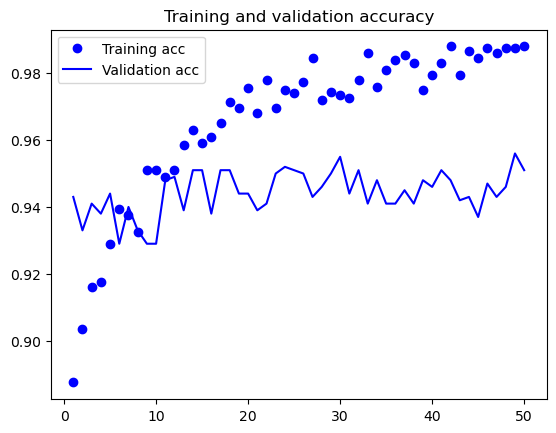

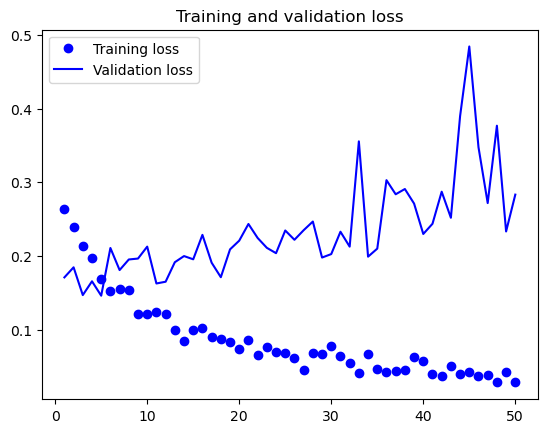

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Step 5: Fine Tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

<img width="180" alt="fine_tuning" src="https://user-images.githubusercontent.com/25600601/134777551-3bde69f6-03e8-4dc5-81a8-3616695ea0bc.png">


We have stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations
previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follow:

1 Add your custom network on top of an already-trained base network.    
2 Freeze the base network.   
3 Train the part you added.   
4 Unfreeze some layers in the base network.   
5 Jointly train both these layers and the part you added.   

You already completed the first three steps when doing feature extraction. Let’s proceed with step 4: you’ll unfreeze your conv_base and then freeze individual layers inside it.

You’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following:

 Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.

 The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset. Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. Let’s set this up, starting from where you left off in the previous example.

## Step 5A. Freezing all layers up to a specific one

In [121]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

# Load pre-trained VGG16 model
vgg = vgg16(pretrained=True)

# Remove the final classifier layers since we only want the convolutional base
# VGG16 features are returned up to the last convolutional layer
conv_base = nn.Sequential(*list(vgg.features.children()))

# Define the model
class CustomVGG16(nn.Module):
    def __init__(self, conv_base):
        super(CustomVGG16, self).__init__()
        self.conv_base = conv_base
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 4 * 4, 256)  # Assuming VGG16 with 7x7 feature map after conv layers
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Freeze layers until the 24th layer (index 23)
        for i, param in enumerate(self.conv_base.parameters()):
            if i == 24:
                break
            param.requires_grad = False

    def forward(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model
model = CustomVGG16(conv_base)

Now you can begin fine-tuning the network. You’ll do this with the RMSProp optimizer, using a very low learning rate. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you’re fine-tuning. Updates that are too large may harm these representations.

 ## Step 5B. Fine tuning the model

In [122]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for training data
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Define transformations for validation data (only normalization)
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Assuming 'train_dir' and 'validation_dir' are paths to your directories
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [123]:
from tqdm import tqdm

# Check CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

# Move model to device
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Store training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1)) # Calculate loss - ensure labels are float and have correct shape

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item() * images.size(0)  # Multiply by batch size to get total loss for this batch
        preds = (outputs > 0.5).float() # Convert probabilities to binary predictions
        train_correct += (preds == labels.float().unsqueeze(1)).sum().item() # Count correct predictions

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():  # No need to track gradients during validation
        for images, labels in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))

            # Statistics
            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels.float().unsqueeze(1)).sum().item()

    # Calculate average losses and accuracies for the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss = val_loss / len(validation_loader.dataset)
    val_acc = val_correct / len(validation_loader.dataset)

    # Store the results in the history dictionary
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

CUDA is available. Training on GPU.


Epoch 1/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.72it/s]


Epoch 1/50: Train Loss: 0.3230, Train Acc: 0.8635, Val Loss: 0.1313, Val Acc: 0.9540


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Epoch 2/50: Train Loss: 0.1910, Train Acc: 0.9265, Val Loss: 0.1683, Val Acc: 0.9530


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


Epoch 3/50: Train Loss: 0.1654, Train Acc: 0.9330, Val Loss: 0.1682, Val Acc: 0.9350


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 4/50: Train Loss: 0.1641, Train Acc: 0.9325, Val Loss: 0.2024, Val Acc: 0.9400


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 5/50: Train Loss: 0.1370, Train Acc: 0.9435, Val Loss: 0.1372, Val Acc: 0.9570


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Epoch 6/50: Train Loss: 0.1210, Train Acc: 0.9550, Val Loss: 0.1598, Val Acc: 0.9560


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Epoch 7/50: Train Loss: 0.1096, Train Acc: 0.9550, Val Loss: 0.2257, Val Acc: 0.9550


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 8/50: Train Loss: 0.0997, Train Acc: 0.9615, Val Loss: 0.1803, Val Acc: 0.9500


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch 9/50: Train Loss: 0.0910, Train Acc: 0.9685, Val Loss: 0.2095, Val Acc: 0.9480


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Epoch 10/50: Train Loss: 0.0964, Train Acc: 0.9660, Val Loss: 0.1692, Val Acc: 0.9430


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Epoch 11/50: Train Loss: 0.0748, Train Acc: 0.9720, Val Loss: 0.1514, Val Acc: 0.9540


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Epoch 12/50: Train Loss: 0.0682, Train Acc: 0.9755, Val Loss: 0.2516, Val Acc: 0.9540


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


Epoch 13/50: Train Loss: 0.0819, Train Acc: 0.9705, Val Loss: 0.1640, Val Acc: 0.9540


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch 14/50: Train Loss: 0.0735, Train Acc: 0.9735, Val Loss: 0.1705, Val Acc: 0.9510


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Epoch 15/50: Train Loss: 0.0660, Train Acc: 0.9725, Val Loss: 0.2284, Val Acc: 0.9410


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch 16/50: Train Loss: 0.0776, Train Acc: 0.9725, Val Loss: 0.1952, Val Acc: 0.9540


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Epoch 17/50: Train Loss: 0.0690, Train Acc: 0.9745, Val Loss: 0.1622, Val Acc: 0.9550


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Epoch 18/50: Train Loss: 0.0389, Train Acc: 0.9860, Val Loss: 0.2151, Val Acc: 0.9480


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Epoch 19/50: Train Loss: 0.0622, Train Acc: 0.9785, Val Loss: 0.2181, Val Acc: 0.9440


Epoch 20/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Epoch 20/50: Train Loss: 0.0693, Train Acc: 0.9775, Val Loss: 0.2143, Val Acc: 0.9480


Epoch 21/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Epoch 21/50: Train Loss: 0.0690, Train Acc: 0.9745, Val Loss: 0.1641, Val Acc: 0.9500


Epoch 22/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Epoch 22/50: Train Loss: 0.0451, Train Acc: 0.9860, Val Loss: 0.2337, Val Acc: 0.9490


Epoch 23/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 23/50: Train Loss: 0.0361, Train Acc: 0.9860, Val Loss: 0.2003, Val Acc: 0.9540


Epoch 24/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Epoch 24/50: Train Loss: 0.0362, Train Acc: 0.9900, Val Loss: 0.2462, Val Acc: 0.9530


Epoch 25/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Epoch 25/50: Train Loss: 0.0558, Train Acc: 0.9810, Val Loss: 0.1793, Val Acc: 0.9480


Epoch 26/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


Epoch 26/50: Train Loss: 0.0462, Train Acc: 0.9840, Val Loss: 0.2120, Val Acc: 0.9490


Epoch 27/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 27/50: Train Loss: 0.0387, Train Acc: 0.9825, Val Loss: 0.2886, Val Acc: 0.9500


Epoch 28/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Epoch 28/50: Train Loss: 0.0438, Train Acc: 0.9830, Val Loss: 0.2567, Val Acc: 0.9470


Epoch 29/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Epoch 29/50: Train Loss: 0.0404, Train Acc: 0.9855, Val Loss: 0.2608, Val Acc: 0.9400


Epoch 30/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Epoch 30/50: Train Loss: 0.0352, Train Acc: 0.9905, Val Loss: 0.2251, Val Acc: 0.9590


Epoch 31/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Epoch 31/50: Train Loss: 0.0391, Train Acc: 0.9850, Val Loss: 0.2208, Val Acc: 0.9510


Epoch 32/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


Epoch 32/50: Train Loss: 0.0266, Train Acc: 0.9890, Val Loss: 0.2251, Val Acc: 0.9590


Epoch 33/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


Epoch 33/50: Train Loss: 0.0436, Train Acc: 0.9840, Val Loss: 0.4628, Val Acc: 0.9310


Epoch 34/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Epoch 34/50: Train Loss: 0.0399, Train Acc: 0.9835, Val Loss: 0.2794, Val Acc: 0.9530


Epoch 35/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Epoch 35/50: Train Loss: 0.0393, Train Acc: 0.9835, Val Loss: 0.2011, Val Acc: 0.9540


Epoch 36/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  6.18it/s]


Epoch 36/50: Train Loss: 0.0373, Train Acc: 0.9875, Val Loss: 0.1748, Val Acc: 0.9590


Epoch 37/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Epoch 37/50: Train Loss: 0.0280, Train Acc: 0.9910, Val Loss: 0.2678, Val Acc: 0.9490


Epoch 38/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.37it/s]


Epoch 38/50: Train Loss: 0.0263, Train Acc: 0.9900, Val Loss: 0.2529, Val Acc: 0.9600


Epoch 39/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Epoch 39/50: Train Loss: 0.0339, Train Acc: 0.9885, Val Loss: 0.2235, Val Acc: 0.9550


Epoch 40/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Epoch 40/50: Train Loss: 0.0331, Train Acc: 0.9885, Val Loss: 0.2165, Val Acc: 0.9630


Epoch 41/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch 41/50: Train Loss: 0.0297, Train Acc: 0.9905, Val Loss: 0.2411, Val Acc: 0.9580


Epoch 42/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Epoch 42/50: Train Loss: 0.0147, Train Acc: 0.9960, Val Loss: 0.3067, Val Acc: 0.9590


Epoch 43/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Epoch 43/50: Train Loss: 0.0367, Train Acc: 0.9870, Val Loss: 0.1639, Val Acc: 0.9580


Epoch 44/50 [Val]: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch 44/50: Train Loss: 0.0201, Train Acc: 0.9930, Val Loss: 0.2634, Val Acc: 0.9560


Epoch 45/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


Epoch 45/50: Train Loss: 0.0294, Train Acc: 0.9900, Val Loss: 0.2450, Val Acc: 0.9500


Epoch 46/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


Epoch 46/50: Train Loss: 0.0289, Train Acc: 0.9920, Val Loss: 0.2744, Val Acc: 0.9450


Epoch 47/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


Epoch 47/50: Train Loss: 0.0308, Train Acc: 0.9890, Val Loss: 0.2320, Val Acc: 0.9570


Epoch 48/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 48/50: Train Loss: 0.0278, Train Acc: 0.9895, Val Loss: 0.2419, Val Acc: 0.9570


Epoch 49/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Epoch 49/50: Train Loss: 0.0179, Train Acc: 0.9955, Val Loss: 0.3057, Val Acc: 0.9620


Epoch 50/50 [Val]: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]

Epoch 50/50: Train Loss: 0.0295, Train Acc: 0.9895, Val Loss: 0.2375, Val Acc: 0.9510


Let’s plot the results using the same plotting code as before.

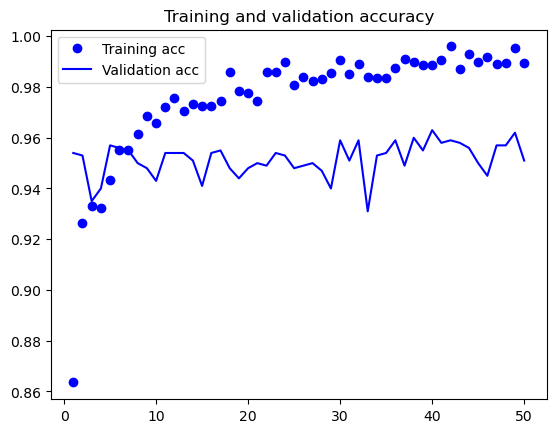

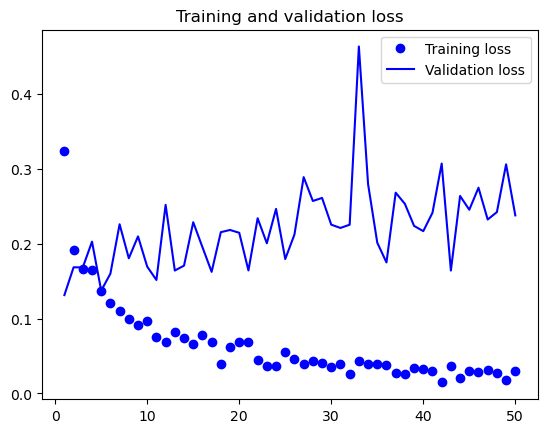

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These curves look noisy. To make them more readable, you can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities.

Here’s a trivial utility function to do this

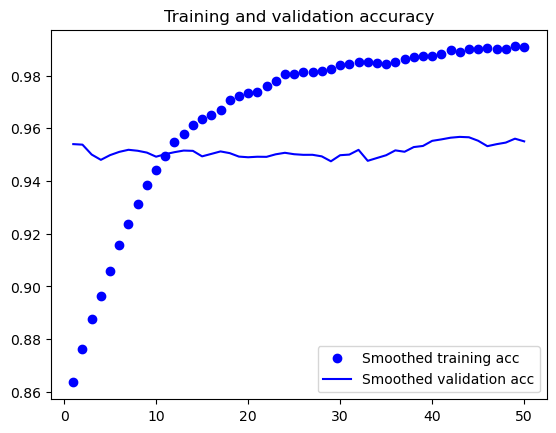

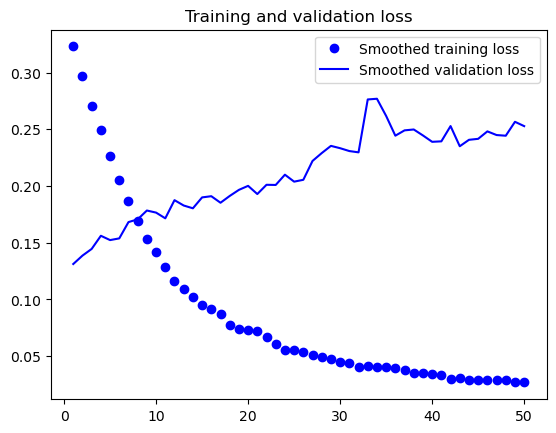

In [125]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
        smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
        smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
        smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
        smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The validation accuracy curve look much cleaner. You’re seeing a nice $4\%$ absolute improvement in accuracy, from about $90\%$ to $94+\%$.

Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). You may wonder, how could accuracy stay stable or improve if the loss isn’t decreasing? The answer is simple: what you display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn’t reflected in the average loss.

You can now finally evaluate this model on the test data:

<div class="alert alert-block alert-success">

### ⚠️ Checkpoint ⚠️

**Recap of Model Performance**
1. Small CNN (70-73%)
2. Small CNN + Data Augmentation and Dropout (83%)
3. VGG16 with frozen Dense Layer (96%)
4. VGG16 with frozen Dense Layer trained end to end with Data Augmentation (96%)
5. VGG16 with frozen base (except 'block5_conv1') and trainable Dense Layer (96%)

Here you get a test accuracy of 94%. You managed to reach this result using only a small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples and this result will already be among the top 5 in 2015!
</div>

# Summary

Here’s what you should take away from the exercises we had:

*  CNN or Convnets are the best machine-learning models for computer vision tasks. It is possible to train one from scratch, even on a very small dataset, with decent results.
*   Overfitting will be the main issue on a small dataset. Data augmentation is a powerful way to fight overfitting when working with image data.    
* Reusing an existing convent on a new dataset via feature extraction is easy. This is a valuable technique for working with small image datasets.   
* In addition to feature extraction, you can use fine-tuning, which adapts to a new problem, such as some of the representations previously learned by an existing model. This pushes performance a bit further. Now, you have a solid set of tools for dealing with image classification problems, particularly small datasets.   

# Good job!
You have learned about one of the most successful and widely used machine learning models for image classification! You should now be ready to start conceptualizing your main project.

Unfortunately, there are two major drawbacks with VGG:
1. It is painfully slow to train.
2. The network architecture weights themselves are quite large (in terms of disk/bandwidth).

Due to its depth and number of fully-connected nodes, VGG is over 533MB for VGG16 and 574MB for VGG19. This makes deploying VGG a tiresome task. We still use VGG in many deep learning image classification problems; however, smaller network architectures are often more desirable (such as SqueezeNet, GoogLeNet, etc.).

# Appendix. ImageNet
Source: https://en.wikipedia.org/wiki/ImageNet

The ImageNet project is a large visual database designed for use in visual object recognition software research. Over 14 million URLs of images have been hand-annotated by ImageNet to indicate what objects are pictured; in at least one million of the images, bounding boxes are also provided. ImageNet contains over 20 thousand categories;a typical category, such as "balloon" or "strawberry", contains several hundred images. The database of annotations of third-party image URLs is freely available directly from ImageNet; however, the actual images are not owned by ImageNet. Since 2010, the ImageNet project runs an annual software contest, the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), where software programs compete to correctly classify and detect objects and scenes. The ImageNet Challenge uses a "trimmed" list of one thousand non-overlapping classes.

A dramatic 2012 breakthrough in solving the ImageNet Challenge is widely considered to be the beginning of the deep learning revolution of the 2010s: "Suddenly people started to pay attention, not just within the AI community but across the technology industry as a whole.


## ImageNet Challenge
Since 2010, the annual ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is a competition where research teams evaluate their algorithms on the given data set, and compete to achieve higher accuracy on several visual recognition tasks. The ILSVRC aims to "follow in the footsteps" of the smaller-scale PASCAL VOC challenge, established in 2005, which contained only about 20,000 images and twenty object classes. The ILSVRC uses a "trimmed" list of only 1000 image categories or "classes", including 90 of the 120 dog breeds classified by the full ImageNet schema. The 2010s saw dramatic progress in image processing. Around 2011, a good ILSVRC classification error rate was 25%. In 2012, a deep convolutional neural net achieved 16%; in the next couple of years, error rates fell to a few percent.  While the 2012 breakthrough "combined pieces that were all there before", the dramatic quantitative improvement marked the start of an industry-wide artificial intelligence boom.By 2015, researchers reported that software exceeded human ability at the narrow ILSVRC tasks. However, as one of the challenge's organizers, Olga Russakovsky, pointed out in 2015, the programs only have to identify images as belonging to one of a thousand categories; humans can recognize a larger number of categories, and also (unlike the programs) can judge the context of an image.

By 2014, over fifty institutions participated in the ILSVRC. In 2015, Baidu scientists were banned for a year for using different accounts to greatly exceed the specified limit of two submissions per week. Baidu later stated that it fired the team leader involved and that it would establish a scientific advisory panel.

In 2017, 29 of 38 competing teams got less than 5% wrong. In 2017 ImageNet stated it would roll out a new, much more difficult, challenge in 2018 that involves classifying 3D objects using natural language. Because creating 3D data is more costly than annotating a pre-existing 2D image, the dataset is expected to be smaller. The applications of progress in this area would range from robotic navigation to augmented reality.

![imagenet_history](https://user-images.githubusercontent.com/25600601/134777794-fc0e42cc-df07-4b65-a276-fb3dba8e27a5.png)

## 1000 Categories of ImageNet

In [ ]:
import pandas as pd
df = pd.read_fwf(DATA_DIR + 'map_clsloc.txt', header = None)
df